In [ ]:
import scipy
import numpy as np
from scipy import constants
import numba
from numba import njit
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import integrate
from scipy import interpolate
#!pip install odeintw
from odeintw import odeintw
from scipy.stats.mstats import gmean
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.ticker import MaxNLocator
import time as Time
import cmath
#import cupy as cp
import queue
import random
import math
from glob import glob
import numpy as np
import scipy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from sklearn.metrics import confusion_matrix as cm
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from sklearn.model_selection import train_test_split

import networkx

2023-05-05 11:16:58.200205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth=True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));

2023-05-05 11:16:59.647273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 11:16:59.649033: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-05 11:16:59.652806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-05 11:16:59.724115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 11:16:59.724321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce

## Utility and stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
@njit
def toStateVec(num):
    v = num - 1
    v |= v >> 1
    v |= v >> 2
    v |= v >> 4
    v |= v >> 8
    v |= v >> 16
    v += 1   
    if v == 1:
        v += 1
    return v


In [ ]:
@njit
def buildHamiltonian(T, omega):
    dim = toStateVec(T.shape[0])
    res = np.zeros((dim, dim), dtype=numba.c16)
    for j in range(T.shape[0]):
        for k in range(T.shape[0]):
            res[j][k] += T[j][k]
    s = res * scipy.constants.hbar * omega
    return s

In [ ]:
def buildInitialState(i, size):
    res = np.zeros([size, size], dtype=complex)
    res[i][i] = 1
    return res

In [ ]:
def GenLine(n):
    res = np.zeros((n,n), dtype=complex)
    for i in range(n):
        for j in range(n):
            if j == i + 1:
                res[i][j] = 1
                res[j][i] = 1
    return res

In [ ]:
Cube =np.array(([0, 1, 1, 0, 1, 0, 0, 0], 
                [1, 0, 0, 1, 0, 1, 0, 0],
                [1, 0, 0, 1, 0, 0, 1, 0],
                [0, 1, 1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1, 1, 0],
                [0, 1, 0, 0, 1, 0, 0, 1],
                [0, 0, 1, 0, 1, 0, 0, 1],    
                [0, 0, 0, 1, 0, 1, 1, 0],), dtype=complex)
Tetra = np.array(([0, 1, 1, 1],
                  [1, 0, 1, 1],
                  [1, 1, 0, 1],
                  [1, 1, 1, 0]), dtype=complex)

In [ ]:
def GenAttenuation(rho, gamma):
    result = np.array(rho, dtype=complex)
    for i in range(rho.shape[0]):
        for j in range(rho.shape[0]):
            if i == j:
                result[i][j] = 0
            else:
                result[i][j] *= gamma
    return result

In [ ]:
def rhs2(y, t):
    return (np.matmul(H, y) - np.matmul(y, H))/(1j * scipy.constants.hbar) - GenAttenuation(y, gamma)

In [ ]:
def calcError(H, t):
    error = -1
    index = 0
    for i in range(H.shape[0]):
        rho0 = buildInitialState(i, toStateVec(H.shape[0]))
        solNoGamma = odeintw(rhs, rho0, t)
        solGamma = odeintw(rhs2, rho0, t)
        eig = np.linalg.eigvalsh(solGamma[1] - solNoGamma[1])
        absVal = np.max(abs(eig))
        if error < absVal:
            index = i
            error = absVal
    rho0 = (buildInitialState(index, toStateVec(H.shape[0])) + buildInitialState(index - 1, toStateVec(H.shape[0])))/2
    solNoGamma = odeintw(rhs, rho0, t)
    solGamma = odeintw(rhs2, rho0, t)
    eig = np.linalg.eigvalsh(solGamma[1] - solNoGamma[1])
    absVal = np.max(abs(eig))
    if error < absVal:
        error = absVal
    rho0 = (buildInitialState(index, toStateVec(H.shape[0])) + buildInitialState((index + 1) % 16, toStateVec(H.shape[0])))/2
    solNoGamma = odeintw(rhs, rho0, t)
    solGamma = odeintw(rhs2, rho0, t)
    eig = np.linalg.eigvalsh(solGamma[1] - solNoGamma[1])
    absVal = np.max(abs(eig))
    if error < absVal:
        error = absVal
    return error

In [ ]:
T = np.array([[2, 0, 0, 0, 0, 0, 0, 0],
             [1, 0, 0, 0, 0, 0, 0, 0],
             [1, 1, 1, 1, 1, 1, 3, 0],
             [0, 0, 0, 0, 1, 0, 0, 0],
             [0, 0, 1, 0, 1, 0, 1, 0],
             [0, 0, 1, 0, 1, 0, 1, 0],
             [0, 0, 1, 1, 1, 1, 1, 0],
             [0, 0, 0, 0, 0, 0, 0, 0],])

In [ ]:
T = np.array([[2, 1, 1, 0, 0],
             [1, 0, 1, 0, 0],
             [1, 1, 3, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0]])

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_progress(model, test_dataset, test_labels, h):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(h.history['accuracy'], 'g-')
    ax[0].plot(h.history['val_accuracy'], 'k--')
    ax[0].legend(ax[0].lines, ['training accuracy', 'validation accuracy'],
              loc='lower center', ncol=2)

    ax[1].plot(h.history['loss'], 'g-')
    ax[1].plot(h.history['val_loss'], 'k--')
    ax[1].legend(ax[1].lines, ['training loss', 'validation loss'],
              loc='upper center', ncol=2)
    y_test=np.argmax(test_labels, axis=1)
    pred = np.argmax(model.predict(test_dataset), axis=1)
    print(ConfusionMatrixDisplay.from_predictions(y_test, pred))

In [ ]:

def plot_progress_binary(model, test_dataset, test_labels, h):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(h.history['accuracy'], 'g-')
    ax[0].plot(h.history['val_accuracy'], 'k--')
    ax[0].legend(ax[0].lines, ['training accuracy', 'validation accuracy'],
              loc='lower center', ncol=2)

    ax[1].plot(h.history['loss'], 'g-')
    ax[1].plot(h.history['val_loss'], 'k--')
    ax[1].legend(ax[1].lines, ['training loss', 'validation loss'],
              loc='upper center', ncol=2)
    y_test=test_labels
    pred = model.predict(test_dataset)
    y_pred_binary = [int(p >= 0.5) for p in pred]
    print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary))

In [ ]:
def decode(A):
    T = np.copy(A)
    start = np.argwhere(T == 2)[0]
    i = start[0]
    j = start[1]
    finish = np.argwhere(T == 3)[0]
    count = 3
    T[finish[0]][finish[1]] = -1
    q = queue.Queue()
    q.put((i, j))
    while not q.empty():
        i, j = q.get()
        if i - 4 >= 0 and T[i - 1][j] == 1:
            if T[i - 4][j] == 1:
                T[i - 4][j] = count
                count += 1
                q.put((i - 4, j))
            elif T[i - 4][j] == -1:
                T[i - 4][j] = 0
                q.put((i - 4, j))
        if j + 4 < T.shape[1] and T[i][j + 1] == 1:
            if T[i][j + 4] == 1:
                T[i][j + 4] = count
                count += 1
                q.put((i, j + 4))
            elif T[i][j + 4] == -1:
                T[i][j + 4] = 0
                q.put((i, j + 4))
        if i + 4 < T.shape[0] and T[i + 1][j] == 1:
            if T[i + 4][j] == 1:
                T[i + 4][j] = count
                count += 1
                q.put((i + 4, j))
            elif T[i + 4][j] == -1:
                T[i + 4][j] = 0
                q.put((i + 4, j))
        if j - 4 >= 0 and T[i][j - 1] == 1:
            if T[i][j - 4] == 1:
                T[i][j - 4] = count
                count += 1
                q.put((i, j - 4))
            elif T[i][j - 4] == -1:
                T[i][j - 4] = 0
                q.put((i, j - 4))
    T[finish[0]][finish[1]] = count
    n = count - 1
    res = np.zeros((n, n), dtype = complex)
    for k in range(2, count + 1):
        curr = np.argwhere(T == k)[0]
        i = curr[0]
        j = curr[1]
        if i - 4 >= 0 and T[i - 4][j] > 1 and T[i - 1][j] == 1:
            res[k - 2][T[i - 4][j] - 2] = 1
        if j + 4 < T.shape[1] and T[i][j + 4] > 1 and T[i][j + 1] == 1:
            res[k - 2][T[i][j + 4] - 2] = 1
        if i + 4 < T.shape[0] and T[i + 4][j] > 1 and T[i + 1][j] == 1:
            res[k - 2][T[i + 4][j] - 2] = 1
        if j - 4 >= 0 and T[i][j - 4] > 1 and T[i][j - 1] == 1:
            res[k - 2][T[i][j - 4] - 2] = 1
    return res

In [ ]:
def generate(count, dim, sparse = (30, 80)):
    result = []
    dim = dim * 2
    for i in range(0, count):
        sp = random.randint(sparse[0], sparse[1])
        num_of_vertices = math.floor(sp * dim * dim / 400)
        
        T = np.zeros((dim, dim), dtype = int)
        i = random.randint(0, dim - 1)
        j = random.randint(0, dim - 1)
        q = queue.Queue()
        q.put((i, j))
        li = -1
        lj = -1
        c = 0
        finish = num_of_vertices - 1
        lst = []
        while c < num_of_vertices:
            if not q.empty():
                li = i
                lj = j
                i, j = q.get()
            lst.append((i, j))    
            if (lst.count((i, j)) > 5):
                T[i][j] = 3
                break
            if li == i and lj == j and c > 1:
                if q.empty():
                    T[i][j] = 3
                    break
                else:
                    i, j = q.get()
            if c == 0:
                T[i][j] = 2
                c += 1
            if ((i - 4 < 0 and j + 4 >= T.shape[1] and i + 4 >= T.shape[0] and j - 4 < 0)):
                T[i][j] = 3
                break
            num = random.randint(1, 4)
            dests = random.sample(range(1, 5), min(num_of_vertices - c, num))
            for d in dests:
                if d == 1 and i - 4 >= 0 and T[i - 1][j] == 0 and T[i - 4][j] != 2:
                    if (c == finish):
                        T[i - 4][j] = 3
                    else:
                        T[i - 4][j] = max(T[i - 4][j], 1)
                    T[i - 1][j] = 1
                    T[i - 2][j] = 1
                    T[i - 3][j] = 1
                    c += 1
                    q.put((i - 4, j))
                if d == 2 and j + 4 < T.shape[1] and T[i][j + 1] == 0 and T[i][j + 4] != 2:
                    if (c == finish):
                        T[i][j + 4] = 3
                    else:
                        T[i][j + 4] = max(T[i][j + 4], 1)
                    T[i][j + 1] = 1
                    T[i][j + 2] = 1
                    T[i][j + 3] = 1
                    c += 1
                    q.put((i, j + 4))
                if d == 3 and i + 4 < T.shape[0] and T[i + 1][j] == 0 and T[i + 4][j] != 2:
                    if (c == finish):
                        T[i + 4][j] = 3
                    else:
                        T[i + 4][j] = max(T[i + 4][j], 1)
                    T[i + 1][j] = 1
                    T[i + 2][j] = 1
                    T[i + 3][j] = 1
                    c += 1
                    q.put((i + 4, j))
                if d == 4 and j - 4 >= 0 and T[i][j - 1] == 0 and T[i][j - 4] != 2:
                    if (c == finish):
                        T[i][j - 4] = 3
                    else:
                        T[i][j - 4] = max(T[i][j - 4], 1)
                    T[i][j - 1] = 1
                    T[i][j - 2] = 1
                    T[i][j - 3] = 1
                    c += 1
                    q.put((i, j - 4))
            
        result.append(np.copy(T))
    return np.array(result)

In [ ]:
def is_quantum(H, Gamma, last):
    global rho0, gamma, t
    n = last + 1
    gamma_list = [Gamma, Gamma + 0.1]
    #gamma_list = [0.01 + i * math.sqrt(0.1) for i in range(0, 10)]
    #gamma_list = np.linspace(0.05,3,20)
    d_t = []
    for g in gamma_list:
        gamma = g
        t = np.linspace(0, 10, 1000)
        rho0 = buildInitialState(0, toStateVec(H.shape[0]))
        solOdeintw = odeintw(rhs2, rho0, t)
        t_last = 0
        while solOdeintw[t_last].diagonal()[last] <= 1/(2*n) and t_last < 999:
            t_last += 1
        if t_last == 999:
            t = np.linspace(10, 20, 500)
            solOdeintw = odeintw(rhs2, rho0, t)
            t_last = 0
            while solOdeintw[t_last].diagonal()[last] <= 1/(2*n) and t_last < 499:
                t_last += 1
            if t_last == 499:
                t = np.linspace(20, 30, 250)
                solOdeintw = odeintw(rhs2, rho0, t)
                t_last = 0
                while solOdeintw[t_last].diagonal()[last] <= 1/(2*n) and t_last < 249:
                    t_last += 1
                if t_last == 249:
                    t = np.linspace(30, 50, 125)
                    solOdeintw = odeintw(rhs2, rho0, t)
                    t_last = 0
                    while solOdeintw[t_last].diagonal()[last] <= 1/(2*n) and t_last < 124:
                        t_last += 1
                    if t_last == 124:
                        t = np.linspace(50, 150, 100)
                        solOdeintw = odeintw(rhs2, rho0, t)
                        t_last = 0
                        while solOdeintw[t_last].diagonal()[last] <= 1/(2*n) and t_last < 99:
                            t_last += 1
                        if t_last == 99:
                            return 0
        d_t.append(t[t_last])
    """fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].plot(gamma_list, d_t)
    axes[1].plot(np.log(gamma_list), np.log(d_t))
    axes[1].plot(np.log([1,5]), np. log([1,5]), color='red')
    axes[1].plot(np.log([Gamma,Gamma]), np.log([0.05, 5]), color='green')
    plt.setp(axes[0], ylabel = 't', xlabel = 'Г')
    plt.setp(axes[1], ylabel = 'log t', xlabel = 'log Г')
    axes[0].grid(True)
    #print(np.log(d_t),np.log(gamma_list))
    axes[1].grid(True)
    dlog = np.log(d_t)
    glog = np.log(gamma_list)
    angles = []
    for i in range(1, len(gamma_list) - 1):
        angles.append((dlog[i + 1] - dlog[i])/(glog[i + 1] - glog[i]))
    print(np.log(d_t))
    print('angles:\n', np.abs(np.log(d_t[1]) - np.log(d_t[0]))/(np.log(gamma_list[0]) - np.log(gamma_list[1])))
    """
    if abs((np.log(d_t[1]) - np.log(d_t[0]))/(np.log(gamma_list[0]) - np.log(gamma_list[1]))) < 0.5:
        return 1
    else:
        return 0

In [ ]:
g = G[2]
d = decode(np.array(g, dtype=int))
path_length = networkx.shortest_path_length(networkx.from_numpy_array(d), source = 0, target = d.shape[0] - 1)
if path_length == 1:
    gamma = 1
else:
    gamma = 3/np.log(path_length)
    #gamma = 2
H = buildHamiltonian(d, 1)
print(gamma)
matplotlib.pyplot.matshow(g)
is_quantum(H, gamma, d.shape[0] - 1)

NameError: name 'G' is not defined

In [ ]:
(0.03982149 - 0.02945871)/(np.log(2.1928964621512246) - np.log(2.1928964621512246 + 0.1))

In [ ]:
G = generate(5000, 8, sparse = (10, 80))

In [ ]:
gamma = 0
def make_labels(G):
    data_tens = []
    data_single = []
    data_first = []
    gammas = []
    labels = []
    for g in G:
        adj = decode(g)
        last = adj.shape[0]
        global H 
        H = buildHamiltonian(adj, 1)
        path_length = networkx.shortest_path_length(networkx.from_numpy_array(adj), source = 0, target = last - 1)
        if path_length == 1:
            gamma = 1
        else:
            gamma = 2.6/np.log(path_length)
            #gamma = 2
        #gamma += random.uniform(0, 1)
        tensor = np.stack((np.array(g, dtype = float), np.full_like(g, gamma, dtype = float)), axis = -1)
        tensor = tensor[:, :, 0:2]
        data_first.append(np.insert(np.array(g, dtype=float), 0, gamma))
        data_tens.append(tensor)
        data_single.append(np.array(g, dtype=int))
        labels.append(is_quantum(H, gamma, last - 1))
    return np.array(data_single), np.array(data_first), np.array(data_tens), np.array(labels)

In [ ]:
def find_const():
    c_list = np.linspace(1.5, 3, 20)
    max_classical = 0
    max_c = -1
    for c in c_list:
        test_data, test_labels = make_labels(G, c)
        if np.count_nonzero(test_labels == 0) > max_classical:
            max_classical = np.count_nonzero(test_labels == 0)
            max_c = c
    return max_classical, max_c

In [ ]:
data_single, data_first, data_tens, test_labels = make_labels(G)

In [ ]:
np.count_nonzero(test_labels==1)

1780

In [ ]:
find_const()

TypeError: make_labels() takes 1 positional argument but 2 were given

In [ ]:
np.savetxt("data_5_tens", data_tens.reshape(5000*16*16*2), delimiter=',')
np.savetxt("data_5_first", data_first.reshape(5000*257), delimiter=',')
np.savetxt("data_5_single", data_single.reshape(5000*256), delimiter=',')
np.savetxt("labels_5_const_last",test_labels, delimiter=',')

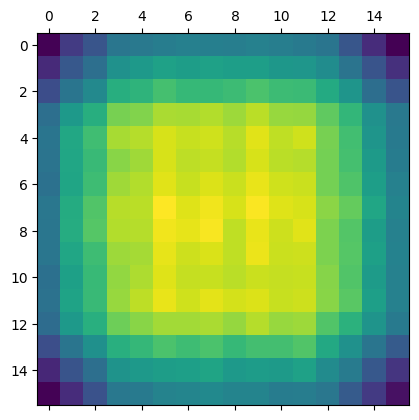

In [ ]:
matplotlib.pyplot.matshow(np.mean(G, axis=0))

In [ ]:
np.count_nonzero(test_labels == 1)

1552

In [ ]:
for g in G:
  

NameError: ignored

1.0

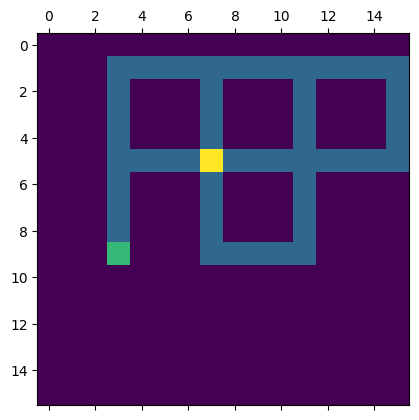

In [ ]:
matplotlib.pyplot.matshow(np.array(test_data[4]))
test_labels[4]

In [ ]:
data, labels = make_labels(G)

TypeError: make_labels() takes 1 positional argument but 3 were given

# NN

In [ ]:
test_data = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/data_5_long_tens", delimiter=',')
test_data = test_data.reshape((5000, 16, 16, 2))
test_labels = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/labels_5_long_tens", delimiter=',')

FileNotFoundError: /content/drive/MyDrive/Colab Notebooks/data_5_long_tens not found.

In [ ]:
test_data = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/data_5_long_first", delimiter=',')
test_data = test_data.reshape((5000, 257))
test_labels = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/labels_5_long_first", delimiter=',')

In [ ]:
labels1 = keras.utils.to_categorical(test_labels, 2)

In [ ]:
test_data = np.expand_dims(test_data, axis=-1) # add a new axis for the channel dimension
test_data = np.reshape(test_data, (-1, 16, 16, 1)) # reshape to (num_samples, 8, 8, 1)

In [ ]:
test_data = data_single

In [ ]:
test_data.shape

(5000, 16, 16, 1)

In [ ]:
test_data = np.loadtxt("data_5_long_first", delimiter=',')
test_data = test_data.reshape((5000,257))
test_labels = np.loadtxt("labels_5_long_first", delimiter=',')

FileNotFoundError: data_5_long_first not found.

In [ ]:
test_data = np.loadtxt("data_10_long_single", delimiter=',')
test_data = test_data.reshape((10000,256))
test_labels = np.loadtxt("labels_10_long", delimiter=',')

In [ ]:
test_data = np.loadtxt("data_10_long_first", delimiter=',')
test_data = test_data.reshape((10000,257))
test_labels = np.loadtxt("labels_10_long", delimiter=',')

In [ ]:
test_data = np.loadtxt("data_10_long_tens", delimiter=',')
test_data = test_data.reshape((10000,16,16,2))
test_labels = np.loadtxt("labels_10_long", delimiter=',')

In [ ]:
test_data = np.loadtxt("data_5_tens", delimiter=',')
test_data = test_data.reshape((5000,16,16,2))
test_labels = np.loadtxt("labels_5_const_last", delimiter=',')

In [ ]:
labels1 = keras.utils.to_categorical(test_labels, 2)

In [ ]:
new_data = []
new_labels = []
count = 1080
for i in range(5000):
    if test_labels[i] == 0 and count > 0:
        new_data.append(test_data[i])
        new_labels.append(test_labels[i])
        count -= 1
    elif test_labels[i] == 1:
        new_data.append(test_data[i])
        new_labels.append(test_labels[i])
test_data=np.array(new_data)
test_labels=np.array(new_labels)

In [ ]:
test_data.shape

(5000, 16, 16, 2)

In [ ]:
#labels1 = keras.utils.to_categorical(test_labels, 2)
labels1 = test_labels
subData = keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
train_x = subData.flow(test_data, labels1, subset = 'training', shuffle=True)
test_x = subData.flow(test_data, labels1, subset = 'validation', shuffle=True)

/home/kng/.local/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (4000, 16, 16, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
/home/kng/.local/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1000, 16, 16, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(test_data, test_labels, train_size=0.8, shuffle=True)

In [ ]:
train_x = train_x.reshape((4000, 65))

In [ ]:
np.count_nonzero(test_x.y == 1)

420

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-04-28 14:29:49.278606: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-28 14:29:49.278829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 14:29:49.279080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 268.26GiB/s
2023-04-28 14:29:49.279157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-28 14:29:49.279198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-28 14:29:49.279232: I tensorflow/stream_executor/platfo

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(2048, activation='relu', input_dim=256))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu', input_dim=256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(16, 16, 2)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(256, (2, 2), activation='relu'))
model.add(keras.layers.Flatten())
#kernel_regularizer=keras.regularizers.l1(0.01)
#model.add(keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)))
#model.add(keras.layers.Dense(512, activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu',  kernel_regularizer=keras.regularizers.l1(0.01)))
model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(4, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
h = model.fit(train_x, validation_data=test_x, batch_size = 8, epochs=70)
#h = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size = 16, epochs=100)

Epoch 1/70
125/125 [==============================] - 1s 5ms/step - loss: 35.6053 - accuracy: 0.4610 - val_loss: 33.7895 - val_accuracy: 0.6550
Epoch 2/70
125/125 [==============================] - 1s 4ms/step - loss: 33.2006 - accuracy: 0.6339 - val_loss: 31.4507 - val_accuracy: 0.6550
Epoch 3/70
125/125 [==============================] - 1s 4ms/step - loss: 30.8830 - accuracy: 0.6442 - val_loss: 29.2008 - val_accuracy: 0.6550
Epoch 4/70
125/125 [==============================] - 1s 4ms/step - loss: 28.6552 - accuracy: 0.6403 - val_loss: 27.0363 - val_accuracy: 0.6550
Epoch 5/70
125/125 [==============================] - 1s 4ms/step - loss: 26.5123 - accuracy: 0.6405 - val_loss: 24.9575 - val_accuracy: 0.6550
Epoch 6/70
125/125 [==============================] - 1s 4ms/step - loss: 24.4551 - accuracy: 0.6459 - val_loss: 22.9652 - val_accuracy: 0.6550
Epoch 7/70
125/125 [==============================] - 1s 4ms/step - loss: 22.4890 - accuracy: 0.6292 - val_loss: 21.0578 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 64)        1216      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 256)         131328    
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

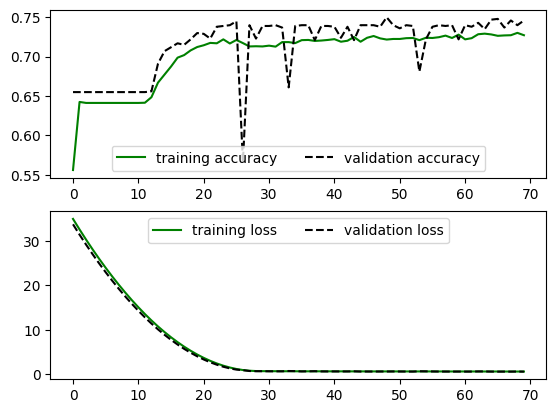

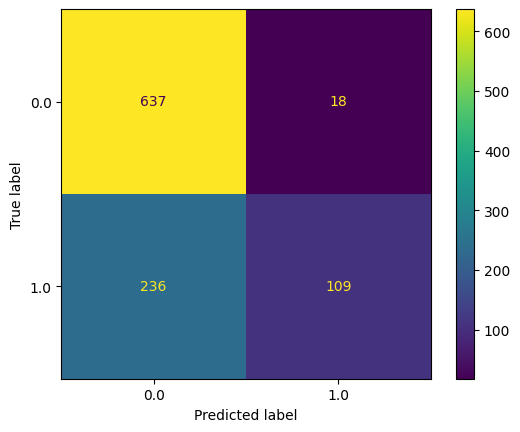

In [ ]:
#plot_progress(model, test_x.x, test_x.y, h)
#plot_progress_binary(model, test_x, test_y, h)
plot_progress_binary(model, test_x.x, test_x.y, h)

In [ ]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


2023-05-02 18:11:19.858056: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-02 18:11:19.858284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 18:11:19.858505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 268.26GiB/s
2023-05-02 18:11:19.858576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-02 18:11:19.858617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-05-02 18:11:19.858647: I tensorflow/stream_executor/platfo

# D t Г

In [ ]:
T = GenLine(16)
H = buildHamiltonian(T, 1)
gammaList = np.linspace(0, 2, 60)
t = np.linspace(0, 20, 60)
dList = []
for time in t:
    for g in gammaList:
        gamma = g
        dList.append(calcError(H, np.array([0, time])))
dList = np.array(dList)

NameError: name 'rhs' is not defined

In [ ]:
dList = dList.reshape([60, 60])
t, gammaList = np.meshgrid(t, gammaList)

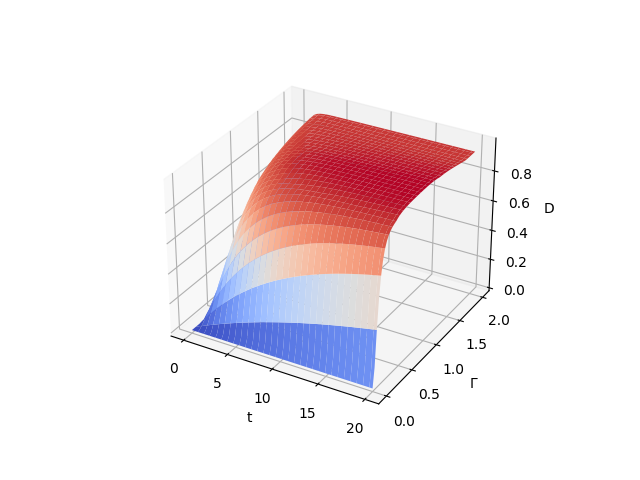

In [ ]:
from matplotlib import cm
%matplotlib widget
#t, gammaList = np.meshgrid(t, gammaList)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(ft, fgammaList, fdList, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_xlabel('t')
ax.set_ylabel('Г')
ax.set_zlabel('D');
#ax.view_init(30, 30)
plt.show()

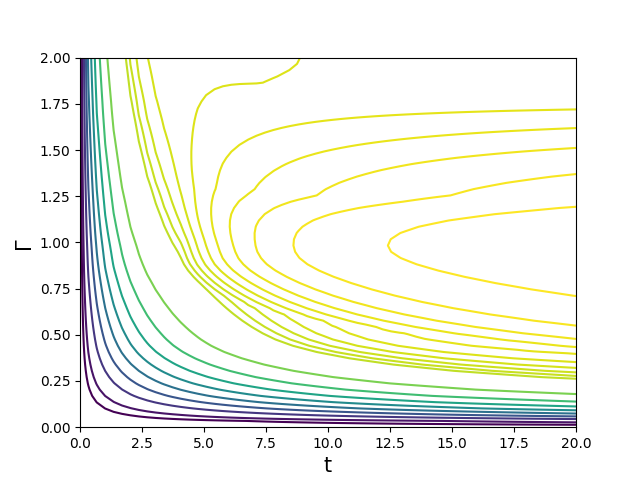

In [ ]:
fig, ax = plt.subplots()
cs = ax.contour(ft, fgammaList, fdList, levels=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('Г', fontsize=15)
plt.show()

In [ ]:
np.savetxt("tf", t , delimiter=',')
np.savetxt("gf", gammaList , delimiter=',')
np.savetxt("df", dList , delimiter=',')

In [ ]:
fgammaList = np.loadtxt("gamma", delimiter=',')
ft = np.loadtxt("t", delimiter=',')
fdList = np.loadtxt("D", delimiter=',')

In [ ]:
(dList - fdList).sum()

0.0

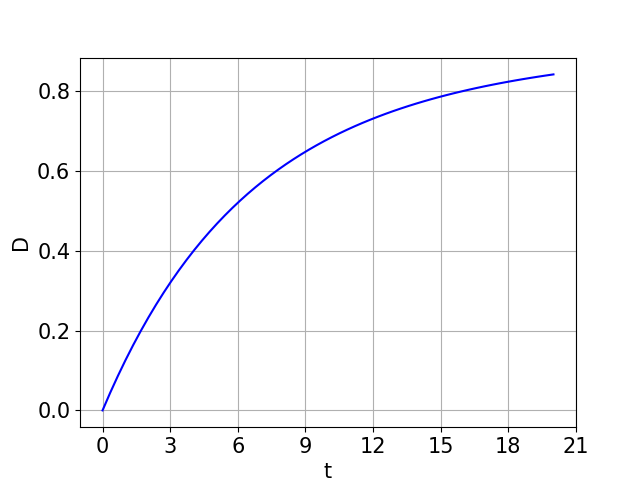

In [ ]:
fig, ax = plt.subplots()
ax.plot(t[6], dList[6], color='blue')
plt.grid(True)
#plt.legend(title='Г = 0.2')
#plt.ylim(0, 1)
#plt.text(0, 0, "Г = 0.2")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('D')
plt.xlabel('t')
plt.show()

In [ ]:
dList[6][1]/t[6][1]

0.13048061092803315

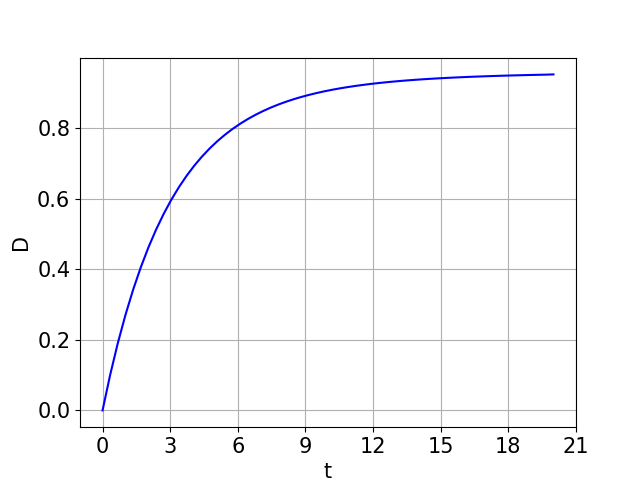

In [ ]:
fig, ax = plt.subplots()
ax.plot(t[12], dList[12], color='blue')
plt.grid(True)
#plt.legend(title='Г = 0.2')
#plt.ylim(0, 1)
#plt.text(0, 0, "Г = 0.2")
plt.rcParams.update({'font.size': 15})
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('D')
plt.xlabel('t')
plt.show()

In [ ]:
dList[12][1]/t[12][1]

0.29785523529097724

## Odeintw

In [ ]:
T = decode(data[7])
H = buildHamiltonian(T, 1)
rho0 = buildInitialState(0, toStateVec(T.shape[0]))
gamma = 0.5

In [ ]:
def rhs(y, t):
    return (np.matmul(H, y) - np.matmul(y, H))/(1j * scipy.constants.hbar)

In [ ]:
solGamma = odeintw(rhs2, rho0, t)

In [ ]:
t = np.linspace(0, 10, 100)
t = np.array([0,20])
solOdeintw = odeintw(rhs, rho0, t)

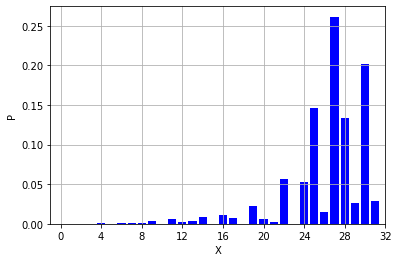

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.array(range(H.shape[0]), dtype=int), solOdeintw[1].diagonal(), color='blue', label='a[0,0]')
#ax.bar(np.array(range(H.shape[0]), dtype=int), solGamma[1].diagonal(), color='red', label='a[0,0]')
plt.grid(True)
plt.xlim(-1, H.shape[0])
#plt.ylim(0, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('P')
plt.xlabel('X')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


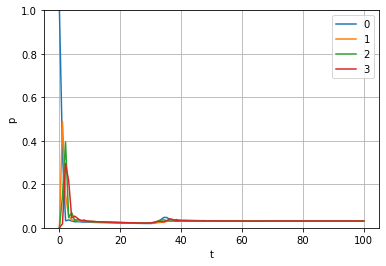

In [ ]:
plt.figure(1)
plt.clf()
color1 = (0.5, 0.4, 0.3)
color2 = (0.2, 0.2, 1.0)
modulus = lambda x : abs(x)
plt.plot(t, solOdeintw[:, 0, 0], label='0')
plt.plot(t, solOdeintw[:, 1, 1], label='1')
plt.plot(t, solOdeintw[:, 2, 2], label='2')
plt.plot(t, solOdeintw[:, 3, 3], label='3')
plt.ylim(0, 1)

plt.legend(loc='best')
#for i in range(t.shape[0]):
#    plt.plot(t, sol[:, i, i], label='a[0,0]')
plt.ylabel('p')
plt.xlabel('t')
plt.grid(True)
plt.show()

# Влияние Г на время перехода на соседа и общее время

Изучить влияние Г на время перехода на соседа и общее время
1. Г = 0 на линии, Г = 1...10, время перехода на соседа(1/2*n) и время в конечную вершину из (1/4 в 4/4) n = n/2, n/ 2*n
2. 


In [ ]:
T = GenLine(16)
H = buildHamiltonian(T, 1)
rho0 = buildInitialState(0, toStateVec(T.shape[0]))
gamma = 0
t = np.linspace(0, 25, 100)

In [ ]:
def adj_time(n):
    global T, H, rho0, gamma, t
    t = np.linspace(0, 300, 600)
    gamma_list = [0.01 + i * math.sqrt(0.1) for i in range(0, 5)]
    print(gamma_list)
    d_t = []
    last_t = []
    for g in gamma_list:
        T = GenLine(n)
        H = buildHamiltonian(T, 1)
        gamma = g
        rho0 = buildInitialState(int(n/4), toStateVec(T.shape[0]))
        solOdeintw = odeintw(rhs2, rho0, t)
        t_last = 0
        diffs = []
        for i in range(int(n/4), n):
            t_0 = 0
            while solOdeintw[t_0].diagonal()[i] == 0:
                t_0 += 1
            t_n = 0
            while solOdeintw[t_n].diagonal()[i] <= 1/(2*n) and t_n < 599:
                t_n += 1
            if t[t_n] - t[t_last] != 0:
                diffs.append(t[t_n] - t[t_0])
            if i == n - 1: 
                last_t.append(t[t_n])
            t_last = t_n
        d_t.append(diffs)
    return d_t, last_t

In [ ]:
def adj_time_gamma(HH, last):
    global H, rho0, gamma, t
    n = last + 1
    t = np.linspace(0, 2 * n, 200)
    #gamma_list = [0.01 + i * math.sqrt(0.1) for i in range(0, 10)]
    gamma_list = [0.01, 0.3, 0.8]
    d_t = []
    last_t = []
    for g in gamma_list:
        
        H = buildHamiltonian(T, 1)
        gamma = g
        rho0 = buildInitialState(int(n/4), toStateVec(T.shape[0]))
        solOdeintw = odeintw(rhs2, rho0, t)
        t_last = 0
        diffs = 0
        for i in range(last, last + 1):
            t_0 = 0
            while solOdeintw[t_0].diagonal()[i] == 0:
                t_0 += 1
            t_n = 0
            while solOdeintw[t_n].diagonal()[i] <= 1/(2*n) and t_n < 199:
                t_n += 1
            if t[t_n] - t[t_0] != 0:
                diffs = t[t_n]
            if i == n - 1: 
                last_t.append(t[t_n])
            t_last = t_n
        d_t.append(diffs)
    print(((np.log(d_t[1]) - np.log(d_t[0]))/(np.log(gamma_list[1]) - np.log(gamma_list[0]))))
    print(((np.log(d_t[2]) - np.log(d_t[1]))/(np.log(gamma_list[2]) - np.log(gamma_list[1]))))
    return d_t, last_t

In [ ]:
d_t_8, last_t_8 = adj_time(H, 11)

NameError: name 'adj_time' is not defined

In [ ]:
d_t_8, last_t_8 = adj_time_gamma(H, 11)

0.03363825686641924
1.3639906983055177


In [ ]:
d_t_8

[3.979899497487437, 3.979899497487437]

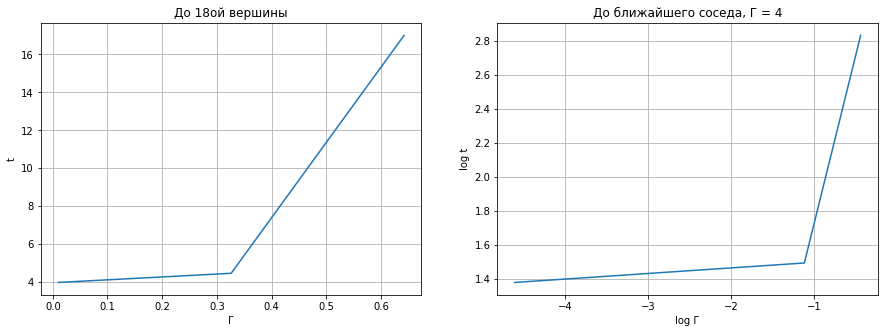

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot([0.01 + i * math.sqrt(0.1) for i in range(0, 3)], d_t_8)
axes[1].plot(np.log([0.01 + i * math.sqrt(0.1) for i in range(0, 3)]), np.log(d_t_8[:6]))
plt.setp(axes[0], ylabel = 't', xlabel = 'Г')
plt.setp(axes[1], ylabel = 'log t', xlabel = 'log Г')
axes[0].set_title('До 18ой вершины')
axes[1].set_title('До ближайшего соседа, Г = 4')
axes[0].grid(True)
axes[1].grid(True)

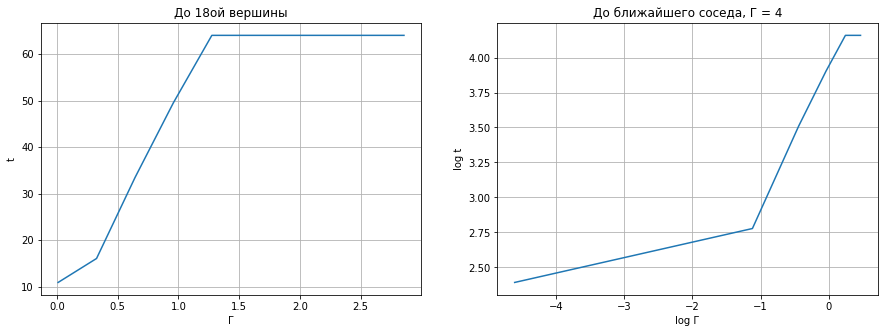

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot([0.01 + i * math.sqrt(0.1) for i in range(0, 10)], d_t_8)
axes[1].plot(np.log([0.01 + i * math.sqrt(0.1) for i in range(0, 6)]), np.log(d_t_8[:6]))
plt.setp(axes[0], ylabel = 't', xlabel = 'Г')
plt.setp(axes[1], ylabel = 'log t', xlabel = 'log Г')
axes[0].set_title('До 18ой вершины')
axes[1].set_title('До ближайшего соседа, Г = 4')
axes[0].grid(True)
axes[1].grid(True)

In [ ]:
np.log([0.01 + i * math.sqrt(0.1) for i in range(0, 6)]), np.log(d_t_8[:6])

(array([-4.60517019, -1.12015947, -0.44245768, -0.0421945 ,  0.24287642,
         0.46445001]),
 array([2.39193878, 2.77760126, 3.50996916, 3.90253086, 4.15888308,
        4.15888308]))

In [ ]:
T = GenLine(32)
H = buildHamiltonian(T, 1)
Gamma = 0
is_quantum(H, 0.6)

[3.44028924 3.51953861]


1

In [ ]:
np.log(0.6)

-0.5108256237659907

In [ ]:
(3.51953861 - 3.44028924)/(-0.4307829160924542 + 0.5108256237659907)

0.9900885702571195

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(range(0, 21), d_t_8[0])
axes[1].plot(range(0, 22), d_t_8[1])
plt.setp(axes[0], ylabel = 't', xlabel = 'n')
plt.setp(axes[1], ylabel = 't', xlabel = 'n')
axes[0].set_title('До ближайшего соседа, Г = 2')
axes[1].set_title('До ближайшего соседа, Г = 4')
axes[0].grid(True)
axes[1].grid(True)

In [ ]:
d_t_8 = np.array(d_t_8)
last_t_8 = np.array(last_t_8)

<ipython-input-99-439329d78092>:2: RuntimeWarning: invalid value encountered in divide
  axes[0].plot(range(0, 21), np.array(d_t_8[1][:21])/d_t_8[0])
<ipython-input-99-439329d78092>:3: RuntimeWarning: divide by zero encountered in log
  axes[1].plot(np.log(range(0, 21)), np.log(d_t_8[0]))


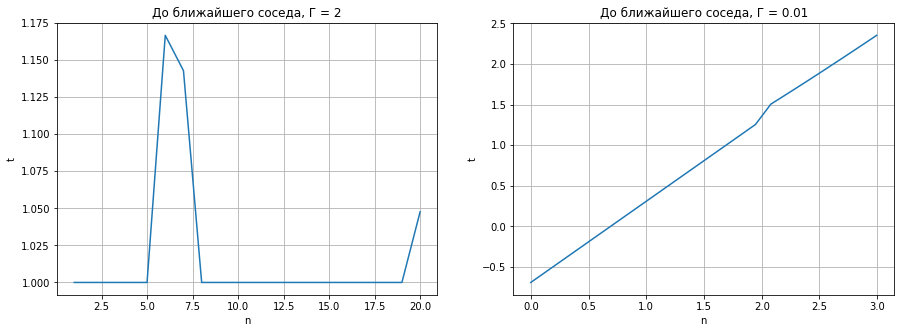

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(range(0, 21), np.array(d_t_8[1][:21])/d_t_8[0])
axes[1].plot(np.log(range(0, 21)), np.log(d_t_8[0]))
plt.setp(axes[0], ylabel = 't', xlabel = 'n')
plt.setp(axes[1], ylabel = 't', xlabel = 'n')
axes[0].set_title('До ближайшего соседа, Г = 2')
axes[1].set_title('До ближайшего соседа, Г = 0.01')
axes[0].grid(True)
axes[1].grid(True)

In [ ]:
np.log(range(0, 22))

<ipython-input-92-73f7777d705f>:1: RuntimeWarning: divide by zero encountered in log
  np.log(range(0, 22))


array([      -inf, 0.        , 0.69314718, 1.09861229, 1.38629436,
       1.60943791, 1.79175947, 1.94591015, 2.07944154, 2.19722458,
       2.30258509, 2.39789527, 2.48490665, 2.56494936, 2.63905733,
       2.7080502 , 2.77258872, 2.83321334, 2.89037176, 2.94443898,
       2.99573227, 3.04452244])

In [ ]:
np.log(d_t_8[0])

<ipython-input-94-06037f1fb089>:1: RuntimeWarning: divide by zero encountered in log
  np.log(d_t_8[0])


array([           -inf, -6.91479123e-01,  1.66805710e-03,  4.07133165e-01,
        6.94815238e-01,  9.17958789e-01,  1.10028035e+00,  1.25443103e+00,
        1.50574545e+00,  1.61110597e+00,  1.70641615e+00,  1.79342753e+00,
        1.87347023e+00,  1.94757821e+00,  2.01657108e+00,  2.08110960e+00,
        2.14173422e+00,  2.19889263e+00,  2.25295986e+00,  2.30425315e+00,
        2.35304331e+00])

In [ ]:
(1.94757821 - 1.66805710e-03)/(2.48490665 - 1.09861229)

1.4036774649360904

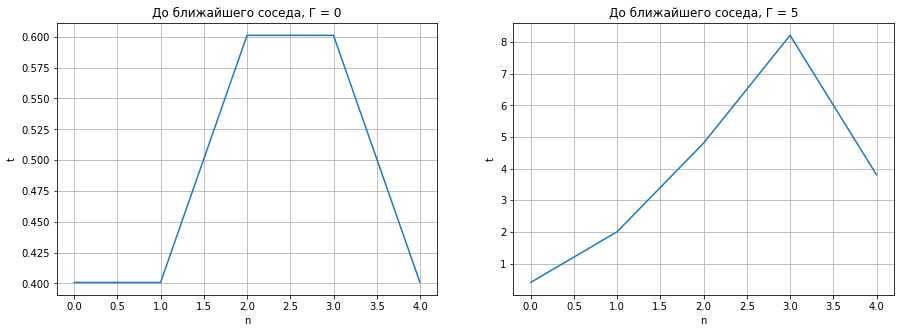

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(range(0, 5), d_t_8[0])
axes[1].plot(range(0, 5), d_t_8[7])
plt.setp(axes[0], ylabel = 't', xlabel = 'n')
plt.setp(axes[1], ylabel = 't', xlabel = 'n')
axes[0].set_title('До ближайшего соседа, Г = 0')
axes[1].set_title('До ближайшего соседа, Г = 5')
axes[0].grid(True)
axes[1].grid(True)

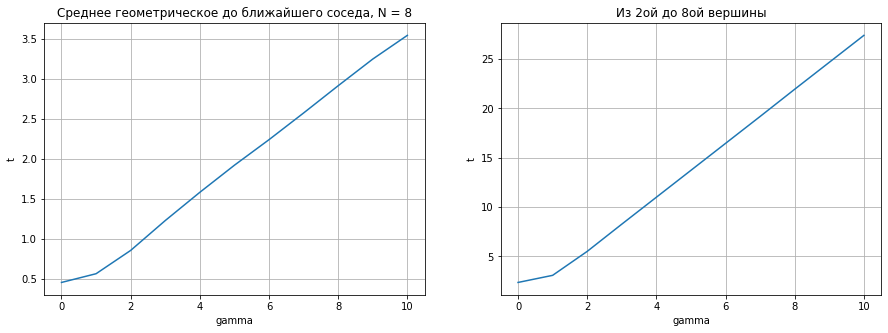

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(range(0, 11), d_t_8)
axes[1].plot(range(0, 11), last_t_8)
plt.setp(axes[0], ylabel = 't', xlabel = 'gamma')
plt.setp(axes[1], ylabel = 't', xlabel = 'gamma')
axes[0].set_title('Среднее геометрическое до ближайшего соседа, N = 8')
axes[1].set_title('Из 2ой до 8ой вершины')
axes[0].grid(True)
axes[1].grid(True)

In [ ]:
(d_t_8[6] - d_t_8[5])/(6 - 5)

0.327450050731773

In [ ]:
d_t_16, last_t_16 = adj_time(16)

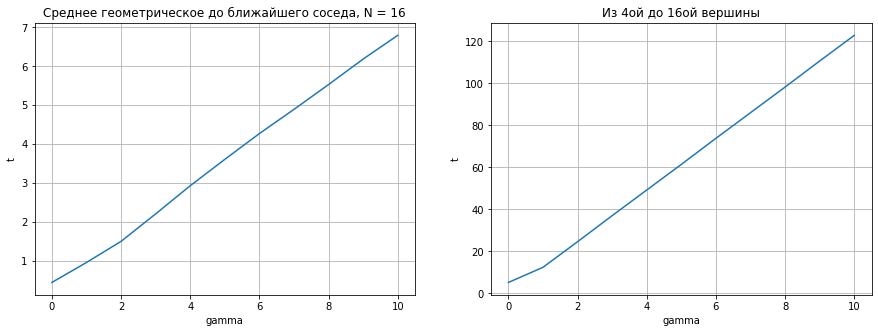

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(range(0, 11), d_t_16)
axes[1].plot(range(0, 11), last_t_16)
plt.setp(axes[0], ylabel = 't', xlabel = 'gamma')
plt.setp(axes[1], ylabel = 't', xlabel = 'gamma')
axes[0].set_title('Среднее геометрическое до ближайшего соседа, N = 16')
axes[1].set_title('Из 4ой до 16ой вершины')
axes[0].grid(True)
axes[1].grid(True)

In [ ]:
d_t_32, last_t_32 = adj_time(32)

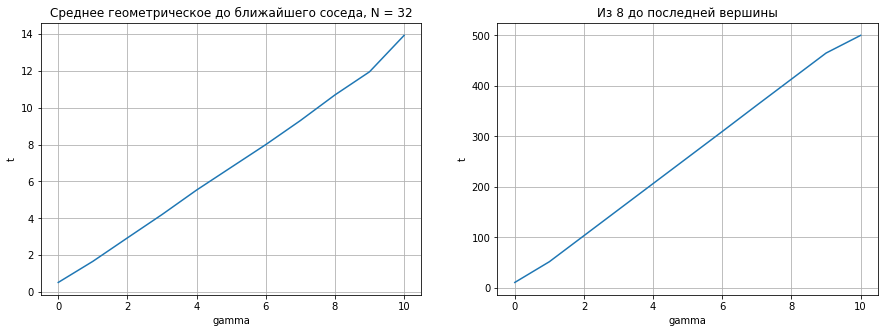

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(range(0, 11), d_t_32)
axes[1].plot(range(0, 11), last_t_32)
plt.setp(axes[0], ylabel = 't', xlabel = 'gamma')
plt.setp(axes[1], ylabel = 't', xlabel = 'gamma')
axes[0].set_title('Среднее геометрическое до ближайшего соседа, N = 32')
axes[1].set_title('Из 8 до последней вершины')
axes[0].grid(True)
axes[1].grid(True)

In [ ]:
d_t_8 = np.array(d_t_8)
last_t_8 = np.array(last_t_8)

<ipython-input-83-feb9e749cb91>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  d_t_8 = np.array(d_t_8)


In [ ]:
last_t_8/d_t_8

ValueError: operands could not be broadcast together with shapes (3,) (3,23) 

In [ ]:
T = GenLine(16)
H = buildHamiltonian(T, 1)
gamma = 3
rho0 = buildInitialState(4, toStateVec(T.shape[0]))
solOdeintw = odeintw(rhs2, rho0, t)
d_t = []
t_last = 0
for i in range(4, 16):
    diffs = []
    t_0 = 0
    while solOdeintw[t_0].diagonal()[i] == 0:
        t_0 += 1
    t_n = 0
    while solOdeintw[t_n].diagonal()[i] <= 1/(2*16) and t_n < 499:
        t_n += 1
    if t[t_n] - t[t_last] != 0:
        d_t.append(t[t_n] - t[t_last])
    t_last = t_n

In [ ]:
np.mean(d_t)- gmean(d_t)

0.784693468115315

In [ ]:
res

[0,
 8,
 24,
 41,
 59,
 72,
 0,
 8,
 27,
 50,
 81,
 95,
 0,
 8,
 31,
 67,
 149,
 170,
 0,
 9,
 37,
 96,
 212,
 256,
 0,
 9,
 44,
 129,
 277,
 342,
 0,
 10,
 52,
 160,
 344,
 427,
 0,
 10,
 60,
 192,
 411,
 498,
 0,
 11,
 69,
 224,
 479,
 498,
 0,
 12,
 79,
 256,
 498,
 498,
 0,
 13,
 88,
 288,
 498,
 498,
 0,
 13,
 97,
 319,
 498,
 498,
 0,
 5,
 19,
 35,
 51,
 68,
 84,
 100,
 117,
 133,
 151,
 158,
 0,
 5,
 21,
 40,
 62,
 87,
 118,
 204,
 305,
 355,
 384,
 382,
 0,
 5,
 23,
 48,
 82,
 139,
 241,
 407,
 498,
 498,
 498,
 497,
 0,
 6,
 26,
 59,
 113,
 206,
 361,
 498,
 498,
 498,
 498,
 497,
 0,
 6,
 29,
 72,
 147,
 273,
 481,
 498,
 498,
 498,
 498,
 497,
 0,
 6,
 33,
 87,
 182,
 340,
 498,
 498,
 498,
 498,
 498,
 498,
 0,
 6,
 37,
 103,
 218,
 408,
 498,
 498,
 498,
 498,
 498,
 498,
 0,
 7,
 42,
 119,
 253,
 475,
 498,
 498,
 498,
 498,
 498,
 498,
 0,
 7,
 47,
 135,
 289,
 498,
 498,
 498,
 498,
 498,
 498,
 498,
 0,
 7,
 52,
 151,
 324,
 498,
 498,
 498,
 498,
 498,
 498,
 498,
 0,

# Interactive odeintw
Программа решает уравнение 
$$i\hbar \frac{\partial\rho}{\partial t} = H\rho - \rho H = [H,\rho] - \gamma * \rho*,$$ где 
$$H = \hbar\Omega\sum_{j,k} |{j}><{k}| * T_{jk},$$
$T$-- матрица смежности, $T_{ij}\in \text{C}, \Omega$ пока равна $1$.

Задается начальное значение $\rho(t=0)$. Результатом работы программы являются значения $\rho(t)$ для заданных $t$.

In [ ]:
import imageio

In [ ]:
T = GenLine(16)
#H = buildHamiltonian(d, 1)
rho0 = buildInitialState(0, toStateVec(H.shape[0]))
gamma = 0.5
t = np.linspace(0, 25, 100)

In [ ]:
solOdeintw = odeintw(rhs2, rho0, t)

In [ ]:
def f(t1):
    fig, ax = plt.subplots()
    xs = np.array(range(H.shape[0]), dtype=int)
    ys = np.array(solOdeintw[t1].diagonal())
    spline = interpolate.CubicSpline(xs, ys, extrapolate=True)
    ax.bar(xs, ys, color='blue')
    plt.plot(xs[:31], spline(xs)[:31] + 0.2, color='red', linewidth=3)
    plt.grid(True)
    plt.xlim(-1, H.shape[0] - 1)
    plt.ylim(0.01, 1)
    ax.set_yscale('log')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('P', fontsize=15)#побольше
    plt.xlabel('node', fontsize=15)#побольше
    plt.savefig(f'./img2/img_{t1}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

In [ ]:
def f2(t1):
    fig, ax = plt.subplots()
    xs = np.array(range(H.shape[0]), dtype=int)
    ys = np.array(solOdeintw[t1].diagonal())
    m = np.argmax(ys)
                  
    spline = interpolate.CubicSpline(xs, ys, extrapolate=True)
    ax.bar(xs, solOdeintw[t1].diagonal(), color='blue', label='a[0,0]')
    plt.plot(xs[:31], spline(xs)[:31] + 0.2, color='red', linewidth=3)
    plt.grid(True)
    plt.xlim(-1, H.shape[0] - 1)
    plt.ylim(0.01, 1)
    #ax.set_yscale('log')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('P')
    plt.xlabel('node')
    plt.show()

In [ ]:
for time in range(0, 360):
    f(time)

In [ ]:
frames = []
for time in range(0, 360):
    image = imageio.v2.imread(f'./img2/img_{time}.png')
    frames.append(image)

In [ ]:
imageio.mimsave('./finalnogamma.gif', # output gif
                frames,          # array of input frames
                fps = 30)         # optional: frames per second

In [ ]:
decode(test_data[8]).shape

(16, 16)

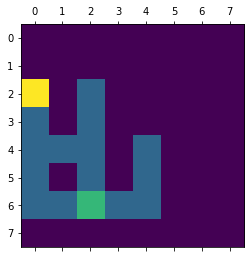

In [ ]:
matplotlib.pyplot.matshow(G[0])

In [ ]:
interact(f2, t1=(0, t.shape[0] - 1));

interactive(children=(IntSlider(value=49, description='t1', max=99), Output()), _dom_classes=('widget-interact…

In [ ]:
np.argmax(solOdeintw[72].diagonal())
solOdeintw[72].diagonal()[13] - solOdeintw[72].diagonal()[17]

(-8.326672684688674e-17+0j)

/home/kng/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


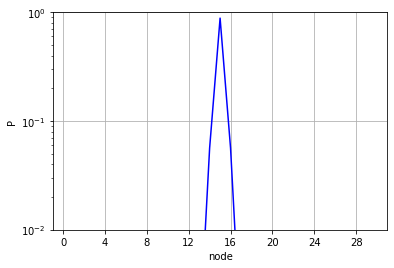

In [ ]:
fig, ax = plt.subplots()
xs = np.array(range(H.shape[0]), dtype=int)
plt.plot(xs, spline(xs), color='blue', label='a[0,0]')
plt.grid(True)
plt.xlim(-1, H.shape[0] - 1)
plt.ylim(0.01, 1)
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('P')
plt.xlabel('node')
plt.show()

In [ ]:
T = GenLine(31)
H = buildHamiltonian(T, 1)
rho0 = buildInitialState(15, toStateVec(T.shape[0]))
t2 = np.linspace(0, 100, 2000)

In [ ]:
solOdeintw2 = odeintw(rhs, rho0, t2)

In [ ]:
def f2(t1):
    fig, ax = plt.subplots()
    ax.bar(np.array(range(H.shape[0]), dtype=int), solOdeintw2[t1].diagonal(), color='blue', label='a[0,0]')
    plt.grid(True)
    plt.xlim(-1, H.shape[0] - 1)
    plt.ylim(0.01, 1)
    ax.set_yscale('log')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('P')
    plt.xlabel('node')
    plt.show()

In [ ]:
interact(f2, t1=(0, t2.shape[0] - 1));

NameError: name 't2' is not defined

# Interacitve scipy.solve_ivp
Программа решает уравнение 
$$i\hbar \frac{\partial\rho}{\partial t} = H\rho - \rho H = [H,\rho],$$ где 
$$H = \hbar\Omega\sum_{j,k} |{j}><{k}| * T_{jk},$$
$T$-- матрица смежности, $T_{ij}\in \text{C}, \Omega$ пока равна $1$.

Задается начальное значение $\rho(t=0)$. Результатом работы программы являются значения $\rho(t)$ для заданных $t$.

In [ ]:
def rhs2(t, y):
    return (H @ y.reshape(H.shape[1], H.shape[1]) - y.reshape(H.shape[1], H.shape[1]) @ H).flatten()/(1j * scipy.constants.hbar)

In [ ]:
T = GenLine(32)
H = buildHamiltonian(T, 1)
rho0 = buildInitialState(0, toStateVec(T.shape[0]))
t = np.linspace(0, 100, 100)
#t = np.array([20,])

In [ ]:
solScipy = scipy.integrate.solve_ivp(rhs2,[0, 100], rho0.flatten(), t_eval = t)

In [ ]:
def f(t1):
    fig, ax = plt.subplots()
    ax.bar(np.array(range(H.shape[0]), dtype=int), solScipy.y[:, t1].reshape(H.shape[0], H.shape[0]).diagonal()[:H.shape[0]], color='blue', label='a[0,0]')
    plt.grid(True)
    plt.xlim(-1, H.shape[0])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('P')
    plt.xlabel('X')
    plt.show()

In [ ]:
interact(f, t1=(0, t.shape[0] - 1));

interactive(children=(IntSlider(value=49, description='t1', max=99), Output()), _dom_classes=('widget-interact…

In [ ]:
solScipy.y

array([[ 0.75592103+0.j        ],
       [ 0.        +0.23590506j],
       [-0.15485582+0.j        ],
       [ 0.        +0.32335155j],
       [ 0.        -0.23590506j],
       [ 0.07664788+0.j        ],
       [ 0.        +0.04811663j],
       [ 0.1022156 +0.j        ],
       [-0.15485582+0.j        ],
       [ 0.        -0.04811663j],
       [ 0.02863257+0.j        ],
       [ 0.        -0.06590621j],
       [ 0.        -0.32335155j],
       [ 0.1022156 +0.j        ],
       [ 0.        +0.06590621j],
       [ 0.13879852+0.j        ]])

# scipy $\rho(t)$

In [ ]:
T = GenLine(4)
H = buildHamiltonian(T, 1)
rho0 = buildInitialState(0, toStateVec(T.shape[0]))
t = np.linspace(0, 10, 100)

In [ ]:
res = scipy.integrate.solve_ivp(rhs2,[0, 10], rho0.flatten(), t_eval = t)

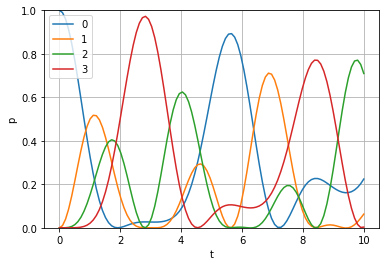

In [ ]:
plt.figure(1)
plt.clf()
color1 = (0.5, 0.4, 0.3)
color2 = (0.2, 0.2, 1.0)
plt.plot(t, res.y[0, :], label='0')
plt.plot(t, res.y[5, :], label='1')
plt.plot(t, res.y[10, :], label='2')
plt.plot(t, res.y[15, :], label='3')
plt.ylim(0, 1)

plt.legend(loc='best')
#for i in range(t.shape[0]):
#    plt.plot(t, sol[:, i, i], label='a[0,0]')
plt.ylabel('p')
plt.xlabel('t')
plt.grid(True)
plt.show()

# Exp
$$\rho(t) = e^{-iHt/\hbar}\rho(0)e^{iHt/\hbar}$$

In [ ]:
T = GenLine(4)
H = buildHamiltonian(T, 1)
rho0 = buildInitialState(0, toStateVec(T.shape[0]))

In [ ]:
def solution(rho0, H, t):
    return scipy.linalg.expm(-1j * H * t/scipy.constants.hbar) @ rho0 @ scipy.linalg.expm(1j * H * t/scipy.constants.hbar)

In [ ]:
import time as Time
startTime = Time.time()
t = np.linspace(0, 100, 100)
t = np.array([20,])
solExp = []
for time in t:
    solExp.append(solution(rho0, H, time))
solExp = np.array(solExp)
endTime = Time.time()
print(endTime - startTime)

0.015727996826171875


In [ ]:
def f(t1):
    fig, ax = plt.subplots()
    ax.bar(np.array(range(H.shape[0]), dtype=int), solExp[t1].diagonal()[:H.shape[0]], color='blue', label='a[0,0]')
    plt.grid(True)
    plt.xlim(-1, H.shape[0])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('P')
    plt.xlabel('X')
    plt.show()

In [ ]:
interact(f, t1=(0, t.shape[0] - 1));

Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
solExp

array([[[ 0.75742884+0.j        ,  0.        +0.23590469j,
         -0.15295136+0.j        ,  0.        +0.32355101j],
        [ 0.        -0.23590469j,  0.0734736 +0.j        ,
          0.        +0.0476374j ,  0.10077145+0.j        ],
        [-0.15295136+0.j        ,  0.        -0.0476374j ,
          0.03088623+0.j        ,  0.        -0.06533626j],
        [ 0.        -0.32355101j,  0.10077145+0.j        ,
          0.        +0.06533626j,  0.13821134+0.j        ]]])

# Eigenvalue problem
$$\rho(t) = \sum_{m,n} \rho_{m,n}e^{-i(E_m - E_n)t/\hbar} |E_m><E_n|,$$ где $\rho_{m,n} = <E_m|\rho(0)|E_n>$

## CPU

In [ ]:
T = GenLine(64)
H = buildHamiltonian(T, 1)
v, E = np.linalg.eigh(H)
rho0ind = 0
rho0 = buildInitialState(rho0ind, toStateVec(T.shape[0]))

In [ ]:
def eigenMethod(rho0, H, v, E, t, size):
    sol = []
    for time in t:
        res = np.zeros((size, size), dtype=complex)
        block = []
        for m in range(size):
            for n in range(size):
                rhomn = (E[m] @ rho0 @ E[n])
                exp = np.exp(-1j * time * (v[m] - v[n])/scipy.constants.hbar)
                res += rhomn * exp * np.outer(E[m], E[n])
        sol.append(res)
    return np.array(sol)

In [ ]:
t = np.array(np.linspace(0, 100, 100))
solCPU = eigenMethod(rho0, H, v, E, t, rho0.shape[0])

In [ ]:
def f(t1):
    fig, ax = plt.subplots()
    ax.bar(np.array(range(H.shape[0]), dtype=int), solCPU[t1].diagonal(), color='blue', label='a[0,0]')
    plt.grid(True)
    plt.xlim(-1, H.shape[0])
    #plt.ylim(0, 1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('P')
    plt.xlabel('X')
    plt.show()

In [ ]:
interact(f, t1=(0, t.shape[0] - 1));

Widget Javascript not detected.  It may not be installed or enabled properly.


## GPU

In [ ]:
T = GenLine(256)
H = cp.asarray(buildHamiltonian(T, 1), dtype=cp.complex64)
v, E = cp.linalg.eigh(H)
rho0ind = 0
rho0 = cp.asarray(buildInitialState(rho0ind, toStateVec(T.shape[0])), dtype=cp.complex64)

In [ ]:
raw_code = r'''
#include <cupy/complex.cuh>
#include <thrust/device_vector.h>
#include <thrust/functional.h>
#include <thrust/sequence.h>
#include <thrust/transform.h>
const int BLOCK_SIZE = 64;
const int DIM_SIZE = 16;
const double d_hbar=1.0545718176461565e-34;

//sum functor for thrust::transform, summs array of matrices
extern "C"
struct sum_functor {
    int N;
    complex<float> *arr;
    complex<float> *result;
    __host__ __device__ sum_functor(int _N, complex<float>* _arr, complex<float>* _result) : N(_N), arr(_arr), result(_result) {};

    __host__ __device__ complex<float> operator()(int n){
        complex<float> sum = result[n];
            for (int i = 0; i < BLOCK_SIZE; i++) {
                sum += arr[N * N * i + n];
            }
        return sum;
    }
};

//outer product multiplied by given exp and rho
extern "C"
__global__ void outer(const complex<float>* E, int size, complex<float>* blockResult, 
                        int m, int n, complex<float> exp, complex<float> rho) {
    int col = blockIdx.y*blockDim.y+threadIdx.y;
    int row = blockIdx.x*blockDim.x+threadIdx.x;
    if (row < size && col < size) {
        blockResult[row * size + col] = exp * rho * E[m * size + row] * E[n * size + col];
    }
}

//compute constants and launch outer product kernels
//outer products are stored in blockResult, i.e. 16 matrices one after another
extern "C" 
__global__ void calcBlock(const complex<float>* v, const complex<float>* E, int size, double t,
                    int rhoind, complex<float>* blockResult, int blockInd) {
    int i = threadIdx.x;
    int j = i + blockInd;
    int m = j / size;
    int n = j % size;
    if (m < size && n < size) {
        const complex<float>hbar(d_hbar);
        complex<float> exp = thrust::exp(complex<float>(0, -1)*(v[m] - v[n]) * complex<float>(t)/hbar);
        complex<float> rho = E[m * size + rhoind] * E[n * size + rhoind];
        dim3 dimGrid((size - 1)/DIM_SIZE + 1, (size - 1) / DIM_SIZE + 1, 1);
        dim3 dimBlock(DIM_SIZE, DIM_SIZE, 1);
        outer<<<dimGrid, dimBlock>>>(E, size, blockResult + i * size * size, m, n, exp, rho);
    }
}

//launch the block calculation, then sum the all matrices in block and add it to the result
//repeat block by block until all size*size  matrices in total are summed
extern "C" 
__global__ void calcSum(const complex<float>* v, const complex<float>* E, int size, double t, int ind,
                    int rhoind,  complex<float>* blockResult, complex<float>* result, int* resultIndexes) {
    for (int i = 0; i < size * size; i += BLOCK_SIZE) {
        calcBlock<<<1, BLOCK_SIZE>>>(v, E, size, t, rhoind, blockResult, i);
        cudaDeviceSynchronize();
        thrust::transform(thrust::device, resultIndexes,
            resultIndexes + size * size,
                result + ind * size * size, sum_functor(size, blockResult, result + ind * size * size));

    }
}
'''

In [ ]:
BLOCK_SIZE = 64
def eigenMethod(rho0, rhoind, H, v, E, t, size):
    kernel=cp.RawModule(code=raw_code,  backend='nvcc', options=('-dc',))
    calcSum = kernel.get_function("calcSum")
    resultIndexes = cp.arange(size * size, dtype=cp.int32)
    result = cp.zeros((t.shape[0], size, size), dtype=cp.complex64)
    
    d_streams = []
    for i in range(0, 32):
        d_streams.append(cp.cuda.stream.Stream(non_blocking=True))
    
    for i in range(0, t.shape[0]):
        with d_streams[i % 32]:
            blockResult = cp.zeros((BLOCK_SIZE, size, size), dtype=cp.complex64)
            calcSum((1,), (1,), (cp.array(v, dtype=cp.complex64), cp.array(E.flatten(), dtype=cp.complex64), size, cp.float64(t[i]), i, rhoind, blockResult, result, resultIndexes))
    
    for stream in d_streams:
        stream.synchronize()
    return result

In [ ]:
import time    
from cupyx.profiler import benchmark
t = cp.array(np.linspace(0, 100, 100))
start_gpu = cp.cuda.Event()
end_gpu = cp.cuda.Event()
start_gpu.record()
start_cpu = time.perf_counter()
sol = eigenMethod(rho0, rho0ind, H, v, E, t, rho0.shape[0])
end_cpu = time.perf_counter()
end_gpu.record()
end_gpu.synchronize()
t_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
t_cpu = end_cpu - start_cpu
t_gpu/1000


42.09538671875

In [ ]:
def f(t1):
    fig, ax = plt.subplots()
    ax.bar(np.array(range(H.shape[0]), dtype=int), cp.asnumpy(sol[t1].diagonal()), color='blue', label='a[0,0]')
    plt.grid(True)
    plt.xlim(-1, H.shape[0])
    #plt.ylim(0, 1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('P')
    plt.xlabel('X')
    plt.show()

In [ ]:
interact(f, t1=(0, t.shape[0] - 1));

Widget Javascript not detected.  It may not be installed or enabled properly.


## Validation
### Odeintw & Eigen method

In [ ]:
solEigen = cp.asnumpy(sol)

In [ ]:
error = 0
for i in range(t.shape[0]):
    error += solEigen[i].trace() - solExp[i].trace()
abs(error)

6.785721408428628e-05